<a href="https://colab.research.google.com/github/Pratichhya/ForestFire/blob/main/forestFire_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio

     |████████████████████████████████| 19.1MB 1.4MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import rasterio

In [3]:
dataframe=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ranPtgenerated.csv",delimiter=";")

In [4]:
#statistical distribution of data
statistical= dataframe.describe()

In [5]:
dataframe.head()

,OBJECTID,CID,blue,green,red,nir,swir,GT
0,1,1,380.0,634.0,1004.0,1626.0,2898.0,0.0
1,2,1,248.0,406.0,544.0,1402.0,1328.0,1.0
2,3,1,771.0,1046.0,1396.0,2186.0,2787.0,0.0
3,4,1,585.0,847.0,1124.0,1970.0,3440.0,0.0
4,5,1,1334.0,716.0,837.0,2066.0,1688.0,0.0


In [6]:
dataframe = dataframe.dropna(how='any',axis=0) 

In [7]:
#separation of x and y
x = dataframe.drop(['GT','CID','OBJECTID'], 1)
y = dataframe.iloc[:, -1:]

In [8]:
xx=x.to_numpy()
yy=y.to_numpy().squeeze()
print("shapes,",xx.shape,yy.shape)

shapes, (9995, 5) (9995,)


In [9]:
#split training and testing set from main dataset
x_train,x_test,y_train,y_test = train_test_split(xx,yy,test_size = 0.2)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.1)

Training the model

In [10]:
#fit the model with linear kernel
model_linear = SVC(kernel = "linear")
model_linear.fit(x_train,y_train)

#predict
pred_test_linear = model_linear.predict(x_test)

In [11]:
#fit the model with radial kernel
model_rbf = SVC(kernel = "rbf")
model_rbf.fit(x_train,y_train)

#predict
pred_test_rbf = model_rbf.predict(x_test)

In [12]:
#confusion matrix
print("Confusion matrix for Liner Kernel:")
print(confusion_matrix(y_test, pred_test_linear))

print("Confusion matrix for Radial Kernel:")
print(confusion_matrix(y_test, pred_test_rbf))

Confusion matrix for Liner Kernel:
[[832 122]
 [173 872]]
Confusion matrix for Radial Kernel:
[[780 174]
 [ 84 961]]


In [13]:
#evaluating linear kernel model
# Model Accuracy: how often is the classifier correct?
print("Accuracy by Linear Kernel:",metrics.accuracy_score(y_test, pred_test_linear))

#evaluating linear kernel model
# Model Accuracy: how often is the classifier correct?
print("Accuracy by Radial Kernel:",metrics.accuracy_score(y_test, pred_test_rbf))

Accuracy by Linear Kernel: 0.8524262131065533
Accuracy by Radial Kernel: 0.870935467733867


In [14]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision by Linear Kernel:",metrics.precision_score(y_test, pred_test_linear))
print("Precision by Radial Kernel:",metrics.precision_score(y_test, pred_test_rbf))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall by Linear Kernel:",metrics.recall_score(y_test, pred_test_linear))
print("Recall by Radial Kernel:",metrics.recall_score(y_test, pred_test_rbf))

Precision by Linear Kernel: 0.8772635814889336
Precision by Radial Kernel: 0.8466960352422908
Recall by Linear Kernel: 0.8344497607655502
Recall by Radial Kernel: 0.9196172248803828


Testing the model

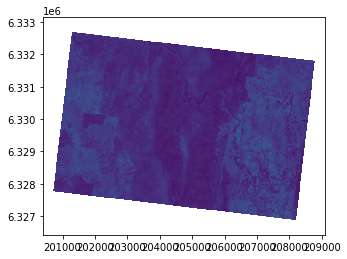

In [34]:
#to load satellite image load it with raster io
from rasterio.plot import show
fp = r'/content/drive/MyDrive/Colab Notebooks/stacked_test_clipped.tif'
img = rasterio.open(fp)
show(img)

In [35]:
blue=img.read(1).flatten()
green=img.read(2).flatten()
red=img.read(3).flatten()
nir=img.read(4).flatten()
swir=img.read(5).flatten()

In [36]:
dataread=img.read()
dataread.shape

(5, 672, 870)

In [37]:
data=np.stack([blue,green,red,nir,swir],axis=1)

In [38]:
data.shape

(584640, 5)

In [39]:
results=model_rbf.predict(data)

In [40]:
preds=results.reshape((672, 870))

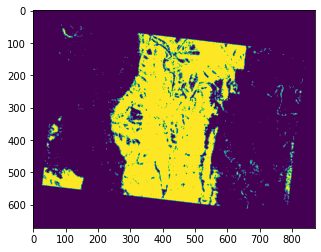

In [41]:
import matplotlib.pyplot as plt
plt.imshow(preds.astype(int))

In [42]:
# Register GDAL format drivers and configuration options with a
# context manager.
with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = img.profile

    # And then change the band count to 1, set the

    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='lzw',
        nodata=0
        )

    with rasterio.open('/content/drive/MyDrive/Colab Notebooks/RBF_SVM_prediction_test.tif', 'w', **profile) as dst:
        dst.write(preds.astype(rasterio.uint8), 1)


In [43]:
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0, 'width': 870, 'height': 672, 'count': 1, 'crs': CRS.from_epsg(32756), 'transform': Affine(9.998369681922753, 0.0, 200391.72329467698,
       0.0, -9.987380313523492, 6333139.604107562), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}